In [1]:
import numpy
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
hypertension_patients = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/hypertension_patients")
print(hypertension_patients.shape)
print(list(hypertension_patients.columns))
hypertension_patients.head()

(58976, 4)
['subject_id', 'hadm_id', 'hypertension', 'train']


,subject_id,hadm_id,hypertension,train
0,73037,192662,1,1
1,25763,195141,1,1
2,40310,157609,0,1
3,65416,171418,1,1
4,26263,105662,1,1


In [3]:
hypertension_charts = pd.read_csv("/home/pulkitmathur1800/csc2548_ml4h/hypertension_charts")
print(hypertension_charts.shape)
print(list(hypertension_charts.columns))
hypertension_charts.head()

(9464062, 5)
['subject_id', 'hadm_id', 'charttime', 'itemid', 'valuenum']


,subject_id,hadm_id,charttime,itemid,valuenum
0,36,165660,2134-05-12 13:00:00,220045,86.0
1,36,165660,2134-05-12 13:00:00,220181,84.0
2,36,165660,2134-05-12 13:00:00,220210,21.0
3,36,165660,2134-05-12 14:00:00,220045,85.0
4,36,165660,2134-05-12 14:00:00,220181,65.0


In [4]:
#filtering heart rate data
heart_rate_data = hypertension_charts.loc[hypertension_charts['itemid'] == 220045]
heart_rate_data.count()

subject_id    2762225
hadm_id       2762225
charttime     2762225
itemid        2762225
valuenum      2762225
dtype: int64

In [5]:
#removing patient with fewer than 2 heart rate measurement
hr = pd.core.frame.DataFrame(heart_rate_data.groupby(['subject_id','hadm_id'],as_index = False).valuenum.agg(['count'])).reset_index() 
hr = hr.loc[hr['count']<2]
heart_rate_data = heart_rate_data.loc[~(heart_rate_data['subject_id'].isin(hr['subject_id']) & heart_rate_data['hadm_id'].isin(hr['hadm_id']))]
heart_rate_data.count()

subject_id    2762212
hadm_id       2762212
charttime     2762212
itemid        2762212
valuenum      2762212
dtype: int64

In [6]:
#mean
hr_mean_max_min = pd.core.frame.DataFrame(heart_rate_data.groupby(['subject_id','hadm_id']).valuenum.agg(['mean','max','min'])).reset_index()  
hr_mean_max_min.count()

subject_id    21911
hadm_id       21911
mean          21911
max           21911
min           21911
dtype: int64

In [7]:
#adding hypertension and train column
hr_mean_max_min = pd.merge(hypertension_patients, hr_mean_max_min, on=['subject_id','hadm_id'], how='inner')
hr_mean_max_min = hr_mean_max_min.drop(['subject_id','hadm_id'],axis=1)
hr_mean_max_min.head()

,hypertension,train,mean,max,min
0,1,1,91.714286,107.0,67.0
1,0,1,111.732143,152.0,80.0
2,1,1,96.074074,108.0,78.0
3,0,0,71.750000,84.0,60.0
4,0,1,72.875000,111.0,32.0


In [8]:
X = hr_mean_max_min.drop(['hypertension'],axis=1)
X_train,X_test = X.loc[X['train']==1],X.loc[X['train']==0]
X_train,X_test = X_train.drop(['train'],axis=1),X_test.drop(['train'],axis=1)
Y = hr_mean_max_min[['hypertension','train']] 
Y_train,Y_test = Y.loc[Y['train']==1],Y.loc[Y['train']==0]
Y_train,Y_test = Y_train.drop(['train'],axis=1).values.squeeze(),Y_test.drop(['train'],axis=1).values.squeeze()

In [9]:
classifier = LogisticRegression(random_state=0,penalty="l2", C=1)
classifier.fit(X_train, Y_train)
Y_pred = classifier.predict(X_test)
matrix = confusion_matrix(Y_test, Y_pred)
print(matrix)

[[3775    1]
 [2835    2]]


In [10]:
print("Accuracy: ",classifier.score(X_train, Y_train))
print("AUC: ",roc_auc_score(Y_pred,Y_test))

Accuracy:  0.561968884822
AUC:  0.618885526979


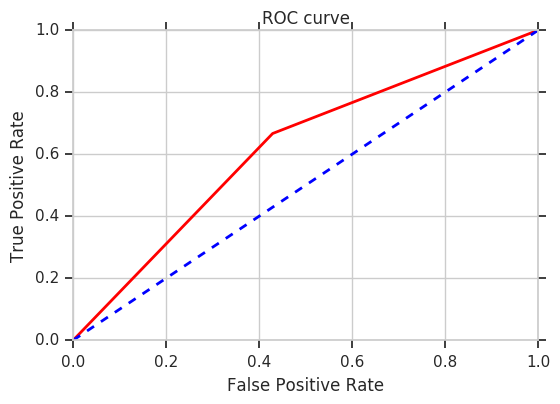

In [11]:
fpr, tpr,_=roc_curve(Y_pred,Y_test)
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [12]:
heart_rate_data.head()
heart_rate_data.loc[(heart_rate_data['subject_id'] == 36) & (heart_rate_data['hadm_id'] ==165660)]

,subject_id,hadm_id,charttime,itemid,valuenum
0,36,165660,2134-05-12 13:00:00,220045,86.0
3,36,165660,2134-05-12 14:00:00,220045,85.0
6,36,165660,2134-05-12 15:00:00,220045,87.0
9,36,165660,2134-05-12 16:00:00,220045,91.0
112,36,165660,2134-05-12 06:52:00,220045,94.0
114,36,165660,2134-05-12 07:00:00,220045,92.0
117,36,165660,2134-05-12 07:04:00,220045,91.0
120,36,165660,2134-05-12 08:22:00,220045,89.0
122,36,165660,2134-05-12 09:00:00,220045,87.0
125,36,165660,2134-05-12 10:00:00,220045,80.0


In [13]:
#preparing the data for LSTM
data = pd.core.frame.DataFrame(heart_rate_data.groupby(['subject_id','hadm_id']).valuenum.apply(list)).reset_index()
data = pd.merge(hypertension_patients, data, on=['subject_id','hadm_id'], how='inner')
data = data.drop(['subject_id','hadm_id'],axis=1)
data.head()

,hypertension,train,valuenum
0,1,1,"[82.0, 89.0, 93.0, 103.0, 104.0, 101.0, 105.0,..."
1,0,1,"[128.0, 129.0, 129.0, 135.0, 134.0, 134.0, 134..."
2,1,1,"[97.0, 99.0, 94.0, 92.0, 93.0, 92.0, 96.0, 94...."
3,0,0,"[82.0, 84.0, 61.0, 60.0]"
4,0,1,"[40.0, 38.0, 36.0, 44.0, 43.0, 47.0, 47.0, 66...."


In [18]:
X = data.drop(['hypertension'],axis=1)
X_train,X_test = X.loc[X['train']==1],X.loc[X['train']==0]
X_train,X_test = X_train.drop(['train'],axis=1),X_test.drop(['train'],axis=1)
Y = data[['hypertension','train']] 
Y_train,Y_test = Y.loc[Y['train']==1],Y.loc[Y['train']==0]
Y_train,Y_test = Y_train.drop(['train'],axis=1).values.squeeze(),Y_test.drop(['train'],axis=1).values.squeeze()

In [25]:
X_train = numpy.array(X_train)
X_train.shape

(15298, 1)

In [30]:
X_train[0]

array([ list([82.0, 89.0, 93.0, 103.0, 104.0, 101.0, 105.0, 96.0, 91.0, 89.0, 85.0, 87.0, 71.0, 84.0, 78.0, 107.0, 106.0, 101.0, 89.0, 102.0, 98.0, 96.0, 67.0, 71.0, 91.0, 85.0, 87.0, 98.0, 90.0, 75.0, 100.0, 91.0, 95.0, 78.0, 84.0, 89.0, 93.0, 96.0, 96.0, 95.0, 94.0, 92.0, 92.0, 96.0, 87.0, 98.0, 102.0, 93.0, 102.0])], dtype=object)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers import LSTM

model = Sequential()
model.add(Flatten(input_shape=(1)))
model.add(Dense(64, init='uniform', activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,init='normal', activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')
X_train = X_train['valuenum'].tolist()
model.fit(X_train, Y_train, batch_size=16, epochs=10)
score = model.evaluate(X_test, Y_test, batch_size=16)
print(score)

Using TensorFlow backend.


TypeError: 'int' object is not iterable